In [2]:
import tensorflow as tf

tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

108512/108512 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


'./datasets/ridership.tgz'

In [8]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


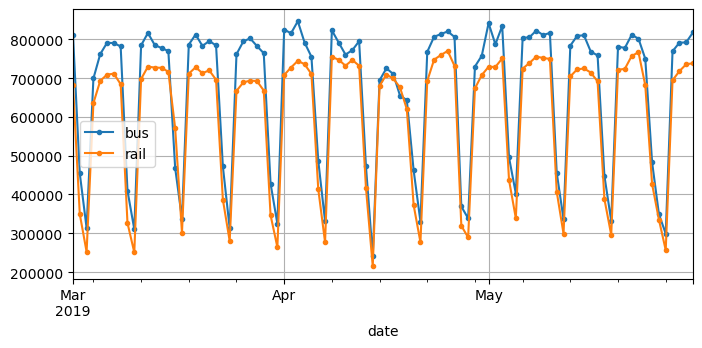

<Axes: xlabel='date'>

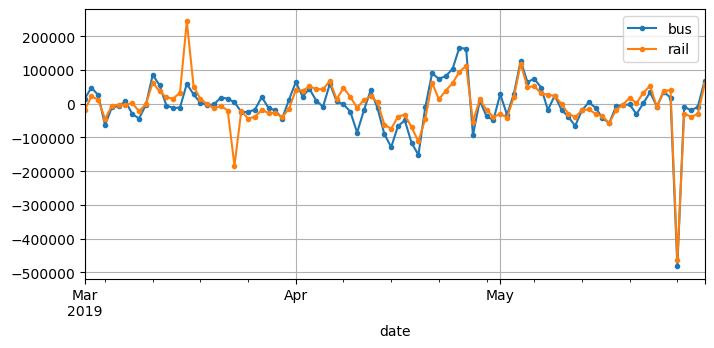

In [10]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

df[["bus", "rail"]].diff(7)["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))

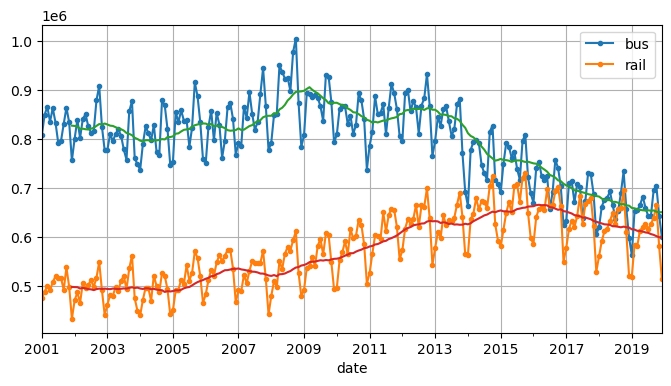

In [14]:
period = slice("2001", "2019")
df_monthly = df.resample('ME').mean(numeric_only=True)  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean(numeric_only=True)

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()


In [15]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)


In [16]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500


/opt/anaconda3/envs/deep-learning-intro-course/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0487 - mae: 0.2498 - val_loss: 0.0100 - val_mae: 0.1096
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116 - mae: 0.1226 - val_loss: 0.0060 - val_mae: 0.0797
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0082 - mae: 0.0947 - val_loss: 0.0057 - val_mae: 0.0773
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0078 - mae: 0.0879 - val_loss: 0.0052 - val_mae: 0.0735
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0067 - mae: 0.0826 - val_loss: 0.0047 - val_mae: 0.0683
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0060 - mae: 0.0781 - val_loss: 0.0045 - val_mae: 0.0675
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0056 - mae: 0.0760 - val_loss: 0.0041 - val_mae: 0.0627
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0058 - mae: 0.0745 - val_loss: 0.0040 - val_mae: 0.0614
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0054 - mae: 0.0